<a href="https://colab.research.google.com/github/Pablitosalinero/Predecir-precio-acciones-keras/blob/master/ETH_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpha_vantage
!pip install pandas

     |████████████████████████████████| 1.3MB 30.8MB/s 
     |████████████████████████████████| 143kB 54.4MB/s 
     |████████████████████████████████| 296kB 55.6MB/s 


In [2]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies

def save_dataset(symbol):
  cc = CryptoCurrencies(key='GE5VTDUFSPUL9LDV')
  cc.output_format='pandas'
  data, meta_data = cc.get_digital_currency_daily(symbol='ETH', market='EUR')
  data.to_csv('./{}_daily.csv'.format(symbol))
symbol = 'ETH'
save_dataset(symbol)

In [3]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 60

def csv_to_dataset(csv_path):
    datos = pd.read_csv(csv_path)

    # print('Datos: ', datos.head(),'\n')

    # Elimina el primer día
    datos  = datos.drop(0, axis=0)

    # Ordena de más viejo a más reciente
    datos = datos.sort_values('date')
    # print('Datos por Fecha: ', datos.head(),'\n')

    # Elimina la columna 'date'  
    datos = datos.drop('date', axis=1)
    print(datos)
    # print("Tipo de de los Datos:", type(datos),'\n')
    # print("Datos: ", datos[:10],'\n')
    scaler = preprocessing.StandardScaler().fit(datos)
    datos_norm = scaler.transform(datos)
    print(datos_norm)
    # print("Datos normalizados", datos_norm[:10],'\n')
    # Usamos los últimos 50 ejemplos para predecir el siguiente valor (open)
    # X
    ohlcv_histories_normalised =      np.array([datos_norm[i  : i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    
    #y - normalized
    next_day_open_values_normalised = np.array([datos_norm[:,0][i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    next_day_open_values = np.array([datos.to_numpy()[:,0][i + history_points].copy() for i in range(len(datos) - history_points)])
    #next_day_open_values = np.expand_dims(next_day_open_values_normalised, -1)
    # print('next_day_open_values shape: ',next_day_open_values.shape)
    #print(next_day_open_values[:10], sep = '\n')

    # Indicadores tecnicos
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # Promedio del Precio de cierre 
        sma = np.mean(his[:,3])
        technical_indicators.append(np.array([sma]))

    technical_indicators = np.array(technical_indicators)
    technical_indicators_normalised = preprocessing.StandardScaler().fit(technical_indicators).transform(technical_indicators)

    # print(next_day_open_values_normalised.shape)

    # Verifica que el número de xs sea igual al número de ys
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]

    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, scaler

In [4]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, scaler = csv_to_dataset('{}_daily.csv'.format(symbol))
#print(ohlcv_histories)
#print(unscaled_y)
#print(next_day_open_values) 

test_split = 0.90
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]
print(y_test)
#print(unscaled_y_test)

     1a. open (EUR)  1b. open (USD)  ...     5. volume  6. market cap (USD)
999      173.034792          209.79  ...  573632.24236         573632.24236
998      184.755200          224.00  ...  841029.12948         841029.12948
997      204.278216          247.67  ...  423740.74030         423740.74030
996      198.785048          241.01  ...  235214.14917         235214.14917
995      201.696592          244.54  ...  350139.15050         350139.15050
..              ...             ...  ...           ...                  ...
5       2152.892960         2610.20  ...  741237.49926         741237.49926
4       2038.089048         2471.01  ...  587364.27358         587364.27358
3       1941.653432         2354.09  ...  767439.49840         767439.49840
2       1955.303872         2370.64  ...  715948.75986         715948.75986
1       2069.695384         2509.33  ...  684183.55622         684183.55622

[999 rows x 10 columns]
[[-0.43587195 -0.43587195 -0.42249687 ... -0.41846057 -0.241373

In [5]:
### Usa tensorflow 1.x
%tensorflow_version 1.x
# Load the TensorBoard notebook extension
%load_ext tensorboard

TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


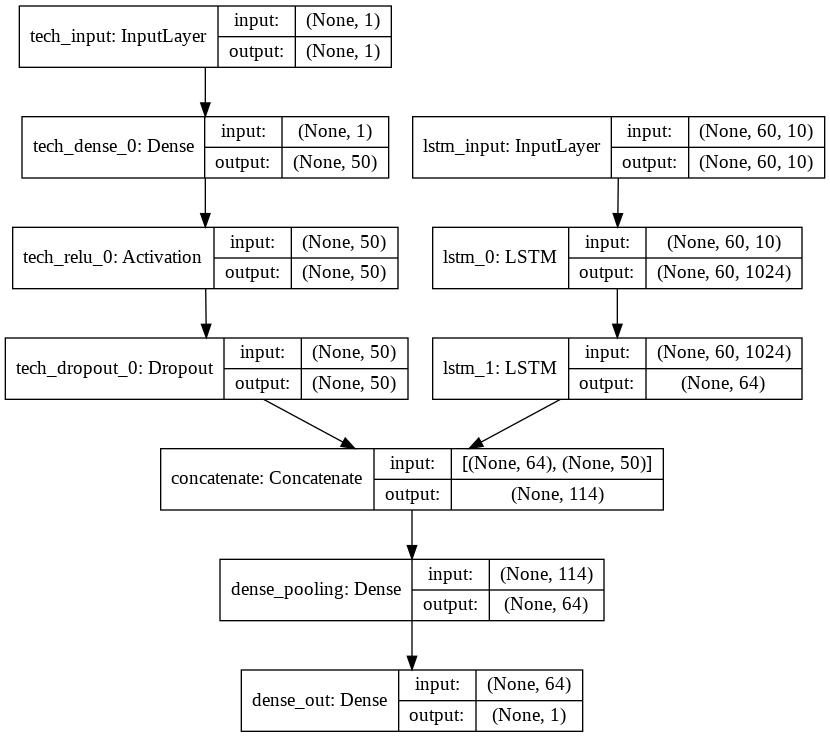

In [6]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
from keras.layers import TimeDistributed



# define two sets of inputs
lstm_input = Input(shape=(history_points, 10), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
# the first branch operates on the first input
x = LSTM(1024, name='lstm_0', return_sequences=True)(lstm_input)
x = LSTM(64, return_sequences=False, name='lstm_1')(x)
#x = TimeDistributed(Dense(64), name='TD_0')(x)
#x = TimeDistributed(Dense(1), name='TD_1') (x)
#x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(50, name='tech_dense_0')(dense_input)
y = Activation("sigmoid", name='tech_relu_0')(y)
y = Dropout(0.1, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam,
              loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [7]:
import tensorflow as tf
import datetime, os

batch_size = 32

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                    histogram_freq=0, 
                                    batch_size=batch_size, 
                                    write_graph=True, 
                                    write_grads=False)

In [ ]:


history = model.fit(
    x=[ohlcv_train, tech_ind_train],
    y=y_train,
    batch_size=batch_size,
    epochs=100,
    shuffle=False,
    validation_split=0.35,
    callbacks=[tensorboard_callback])


Train on 549 samples, validate on 296 samples
Epoch 1/100
549/549 [==============================] - 66s 121ms/step - loss: 0.0166 - val_loss: 0.6173
Epoch 2/100
549/549 [==============================] - 65s 118ms/step - loss: 0.0099 - val_loss: 0.6860
Epoch 3/100
512/549 [==========================>...] - ETA: 3s - loss: 0.0106

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=750) 

In [ ]:
score = model.evaluate([ohlcv_test,tech_ind_test], y_test, 16)
print(score)
import matplotlib.pyplot as plt
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

model.save("ETH-MODEL.h5")

In [ ]:
# Las predicciones estásn normalizadas
y_test_predicted_scaled = model.predict([ohlcv_test, tech_ind_test])
#print(y_test_predicted)

# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(y_test_predicted_scaled), 10) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = y_test_predicted_scaled[:,0]
# inverse transform and then select the right field
y_test_predicted = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
#print(y_test_predicted)
#print(unscaled_y_test)
#real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
#scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
#print(scaled_mse)


In [ ]:
import matplotlib.pyplot as plt
#plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real_scaled = plt.plot(y_test[start:end], label='Real - Scaled')
pred_scaled = plt.plot(y_test_predicted_scaled[start:end], label='Predicted - Scaled')

plt.legend(['Real - Scaled','Predicted - Scaled'])

plt.show()

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()
